# P01: The Pendulum

**Last revised:** Sep 19, 2020 by Heiko Hergert [hergert@frib.msu.edu] <br>
Based on original material by Dick Furnstahl [furnstahl.1@osu.edu]

<div class="alert alert-block alert-warning">

**First draft due:** Oct 5, 2020

</div>

# 1. Introduction
In this project, we will use the example of a pendulum to formulate a general strategy for implementing and solving the dynamics of physical system: We will set up and implement the governing equations of motion of an ideal pendulum, solve them numerically, visualize the solutions, and use a variety of techniques to test the validity along the way. Finally, we will add the dissipative effects that any realistic pendulum will experience. 



# 2. The Ideal Pendulum
## 2.1 Setup
We consider an ideal pendulum consisting of a mass $m$ that is suspended from the ceiling on a massless string of length $l$. When displaced from rest, the mass will perform oscillations under the influence of gravity, without any dissipative losses.


<div class="alert alert-block alert-info">

First, show that the Lagrangian of the pendulum is given by
$$
\begin{align}
  L(\phi,\dot{\phi})=\frac{1}{2}m l^2\dot{\phi}^2 + mgl\cos\phi\tag{1}
\end{align}
$$
(mind the choice of coordinate system and the signs).

Next, show that the Euler-Lagrange equations lead to the following equation of motion (EOM):

$$
\begin{align}
  \ddot\phi = -\frac{g}{l}\sin\phi
  \;.\tag{2}
\end{align}
$$

</div>

Type your work in the cell below. Make sure to switch the Cell Type to Markdown, e.g., via Jupyter's Cell menu. You can use LaTeX synatx in Jupyter Markdown to render formulas - double click the present cell to see examples.


The Lagrangian is defined as the energy given by: $$L=T-V$$
Where T is the kinetic energy and V is the potential energy. 
For T we need the velocity of the mass as: $$v=l\cdot\dot{\phi}$$
So the kinetic energy is given as: $$T=\frac{1}{2}mv^2=\frac{1}{2}m\left(l\cdot\dot{\phi}\right)^2=\frac{1}{2}ml^2\dot{\phi}^2$$
The potential energy, V, is given by:
$$ V = mgy = mgl\left( 1 - cos\phi\right) $$
The combination of the kinetic and potential energies gives the Lagrangians is:
$$ L = T-V = \frac{1}{2}ml^2\dot{\phi}^2 - mgl\left(1-cos\phi\right) $$
This legrangian is then able to differentiated into the Euler-Legrange equations
$$ \frac{\partial L}{\partial \phi} = -mglsin\phi  \hspace{4cm}  \frac{d}{dt}\frac{\partial L}{\partial \dot{\phi}} = \frac{d}{dt}\left(ml^2\dot{\phi}\right) = ml^2\ddot{\phi} $$
Equating these yields:
$$ -mglsin\theta = ml^2\ddot{\phi}$$
Which can be arranged and simplified as:
$$\ddot{\phi} = -\frac{g}{l}sin{\phi}$$

## 2.2 Implementation
(If you are feeling up to it, you can check out SymPy's functionality for Lagrangian mechanics --- the documentation can be found [here](https://docs.sympy.org/latest/modules/physics/mechanics/lagrange.html). You will still need to be able to do some of the math on your own when you're taking an exam, so don't load off all the fun to SymPy.)

The pendulum's EOM is a second order, ***nonlinear*** differential equation. We are going to solve it exactly, which is only possible numerically, as well as with a series of controlled approximations that represent an **effective theory** of the pendulum. The leading-order effective theory corresponds to the frequently used small-angle approximation, which will provide us with an *analytic* solution for validating our results.

We will work to build up code in steps to find the solutions for the pendulum motion, in order to illustrate how a notebook evolves.  We usually don't create the polished version at once!

In [81]:
%matplotlib inline

In [82]:
import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size': 18})


Recall from the Introduction notebook that Python's ODE solvers expect to be passed a vector containing first-order derivatives only. Fill in the following routine to adapt the right-hand side of the EOM to the required format, extracting the current solution from `u_vec` and returning `d(u_vec)/dt` to the ODE solver. 

In [83]:
def ode_rhs_exact(u_vec, t, *params):
    """ 
    Right-hand side (rhs) of the differential equation, with 
    u_vec = [\phi, \dot\phi] and params = [g, R].  Returns the list of
    d(u_vec)/dt, as prescribed by the differential equation.
    
    """
    phi, phidot = u_vec[0], u_vec[1]       # extract phi and phidot from the passed vector
    g, R = params[0], params[1]              # extract g and R from the passed parameters
    return [ u_vec[1], -(g/R)*np.sin(phi) ]

This is the main computational part of the code for now: Set up the initial conditions and run the ODE solver with the routine you have created to produce data.

In [84]:
# parameters
g = 9.8  # in mks units
R = 5    # radius in meters

# absolute and relative tolerances for ode solver
abserr = 1.0e-8
relerr = 1.0e-6

# initial conditions for [phi, phidot]
phi0 = np.pi/180 * 20.  # convert initial phi to radians
u0_vec = phi0, 0

t_max = 15.  # integration time
t_pts = np.arange(0, t_max, 0.01)  # array of time points, spaced 0.01

# Integrate the differential equation and read off phi, phidot (note T!)
phi, phidot = odeint(ode_rhs_exact, u0_vec, t_pts, args=(g, R), 
                     atol=abserr, rtol=relerr).T

Now plot your solutions.

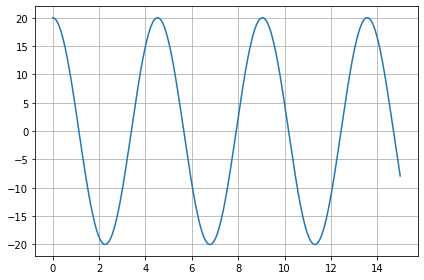

In [85]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(t_pts, 180./np.pi * phi)
plt.grid()
fig.tight_layout()  # make the spacing of subplots nicer

<div class="alert alert-block alert-info">

Let us stop and assess our solution here. Does it make sense, given the behavior we would expect? I.e.,

- **Does the pendulum start at the correct angle?** 
- **Is the time behavior appropriate for an ideal, undamped pendulum?**
</div>

For future use, we now put the code into a function. We can use the syntax in the first line to assign default values to optional arguments (see below for calls to `solve_for_phi` with varying arguments).

In [86]:
def solve_for_phi(phi0, phidot0=0, t_min=0., t_max=1., g=9.8, R=5.):
    """
    Solve the equation of motion for an ideal pendulum.
    The result for t, \phi(t) and \dot\phi(t) are returned for a range
    t_min < t < t_max and a hardwired (for now) time step of 0.01 seconds.
    The ODE solver is odeint from scipy, with specified tolerances. 
    Units are mks and angles are in radians.
    """

    # absolute and relative tolerances for ode solver
    abserr = 1.0e-8
    relerr = 1.0e-6

    # initial conditions for [phi, phidot]
    u0_vec = phi0, 0

    t_pts = np.arange(t_min, t_max, 0.01)

    # Integrate the differential equation
    phi, phidot = odeint(ode_rhs_exact, u0_vec, t_pts, args=(g, R), 
                     atol=abserr, rtol=relerr).T
    
    return t_pts, phi, phidot

<div class="alert alert-block alert-info">

**Check that the function works, i.e., gives you the same result as before.**

</div>

In [87]:
phi0 = np.pi/180 * 20.  # convert initial phi to radians
t_pts, phi, phidot = solve_for_phi(phi0, t_max=15.)

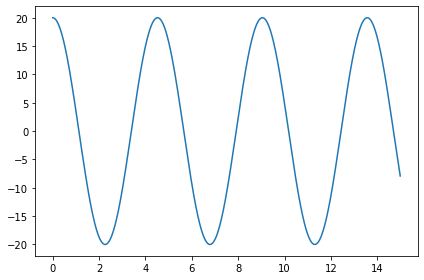

In [88]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(t_pts, 180./np.pi * phi)
fig.tight_layout()  # make the spacing of subplots nicer


## 2.3 Effective Theories
If we look back over the history of physics, we will note that again and again the existing theories of physical phenomena were revealed to be **effective theories**, i.e., limiting cases of more fundamental underlying theories. In fact, nature seems to be best grasped through a "tower" of such effective theories that will allow us to make progress despite not knowing what the ultimate underlying theory - perhaps a theory of everything - is going to be.

Classical mechanics is no different in this regard: It is an effective theory of Quantum Mechanics in the limit where energy can be treated as continuous instead of quantized, which we can formally express as $\frac{\hbar\omega}{E}\ll 1$ (or sometimes as $\hbar\to 0$). Furthermore, it is the limit of Special Relativity for $\frac{v}{c}\ll1$, which is itself a limit of General Relativity for weak gravitational fields. 

### Effective Theories of Gravity
In fact, the treatment of gravity in Introductory Physics is likely your earliest encounter with an effective theory. Gravity is first introduced either in force or potential form as
$$
\begin{equation}
  \vec{F} = m\vec{g}\,, \quad V = mgh\,,\tag{3}
\end{equation}
$$
where $h$ is the elevation of an object with mass $m$ over the surface of the Earth. Some time later, this is revealed to be a limit of the more general expression 
$$
\begin{equation}
  \vec{F} = -G\frac{m_1 m_2}{r^2}\vec{e}_r\,, \quad V = -G\frac{m_1m_2}{r}\,,\tag{4}
\end{equation}
$$
where $\vec{r}$ is the distance between the masses $m_1$ and $m_2$. For the case of an object near the surface of the Earth, we have $m_1=m$, $m_2=M_E$ is the mass of the Earth, and $r=R_E+h$ is the distance of object from the Earth's center of mass, so that 
$$
\begin{align}
  V &= -G\frac{m M_E}{R_E+h} = -G\frac{mM_E}{R_E}\frac{1}{1+h/R_E} \notag\\
  &=-G\frac{mM_E}{R_E} \sum_{n=0}^{\infty} \left(\frac{h}{R_E}\right)^n 
  = -G\frac{mM_E}{R_E}\left(1 - \frac{h}{R_E} + \mathcal{O}\left(\frac{h^2}{R^2_E}\right)\right)\notag\\
  &= -G\frac{mM_E}{R_E} + G\frac{mM_E}{R^2_E}h  + \mathcal{O}\left(\frac{h^2}{R^2_E}\right)\notag\\
  &= V_0 + mgh + \mathcal{O}\left(\frac{h^2}{R^2_E}\right)\,,\tag{5}
\end{align}
$$
where we have introduced $g \equiv G\frac{M_E}{R_E^2}$ and $V_0=-mgR_E$ is the potential at ground level. Thus, the first form of gravity you learn is the leading-order effective theory of Newtonian gravity, Eq. (4). For sufficiently high elevation, we may need to take corrections in $\frac{h}{R_E}$ into account, and once $\frac{h}{R_E}\geq 1$, the geometric series expansion in Eq. (5) is no longer converging. We say that the effective theory **breaks down** at the distance **scale $R_E$**.

### General Strategy
The general strategy for setting up an effective theory consists of identifying a small expansion parameter that is usually associated with a **separation of scales**. In our example, an everyday elevation $h$ is $\mathcal{O}(1\,\text{m})$ to $\mathcal{O}(10\,\text{m})$, which is small compared to the radius of the Earth, $R_E=6.371\times 10^6\,\text{m}$. In nonrelativistic mechanics, $v\ll c$. Moreover, we can neglect whatever the effects of corrections from a hypothetical quantum theory of gravity would be. We then define an expansion in the small parameter and set up what is called a **power-counting scheme**, treating all observables through some order $n$ in the ratio of the small and large scales. We frequently also use the terms leading-order (LO), next-to-leading order (NLO), next-to-next-to-leading order (NNLO) etc.

In the example of gravity, we knew the underlying theory and used it to construct the effective theory for objects near the surface of the Earth. What can we do if the underlying theory is unknown? If we are able to identify a possible new scale - e.g., by noting where deviations form the effective theory behavior become noticeable - we can attempt to **define** the expansion parameter $x$, and make an *ansatz* for the theory:
$$
\begin{align}
   V = \sum_{k=1}^\infty c_k x^k
\end{align}
$$
The expansion coefficients $c_k$ are then constrained by the symmetries of the theory (translational invariance, rotational invariance, etc.), and we can determine them at some given order of the expansion by fitting them to experimental data. The LO theory will fix $c_1$ and observables will have an error of order $\mathcal{O}(x^2)$ from the omitted terms in the expansion. At NLO, we fix $c_1$ and $c_2$, possibly with slightly different values than at LO, and the overall error of the theory will be $\mathcal{O}(x^3)$, and so on. The effective theory can then be used to make predictions for observables that were *not* used to fit the $c_k$. 

# 2.4 Small-Angle Approximation

## 2.4.1 Derivation
Let us now apply the effective theory ideas to the pendulum. Consider $\theta$ as a small expansion parameter.

<div class="alert alert-block alert-info">

Construct the leading-order Lagrangian of the effective theory through the first few orders, and the associated equation of motion. (**Note:** Leading-order does not necessarily mean the first term of the expansion in the angle $\phi$; we want discuss a dynamical system, after all.) 

</div>

$$
\begin{align}
  \mathscr{L}(\phi,\dot{\phi})&=\frac{1}{2}m l^2\dot{\phi}^2 + mgl\cos\phi \rightarrow \mathscr{L}(\phi,\dot{\phi}) \approx \frac{1}{2}m l^2\dot{\phi}^2 + mgl(1 - \frac{\phi^{2}}{2} )\\
  &\frac{\partial}{\phi}\mathscr{L}(\phi,\dot{\phi}) = -mgl\phi \\
  &\frac{\partial}{{\partial\dot\phi}}\mathscr{L} = ml^{2}\dot{\phi} \\
  &\frac{d}{dt}\frac{\partial}{{\partial\dot\phi}}\mathscr{L} = ml^{2}\ddot{\phi} \\
\end{align}
$$
Where we used a second order approxmation for cosine:
$$ \cos(\phi) \approx 1 - \frac{\phi^2}{2} $$
Given the pieces, all that is left to do is put it together into our Lagrange equations of the second kind.
$$
\begin{align}
  &\frac{d}{dt}\frac{\partial}{{\partial\dot\phi}}\mathscr{L} - \frac{\partial}{\phi}\mathscr{L}(\phi,\dot{\phi}) = 0 \\ \\
  & ml^{2}\ddot{\phi} + mgl\phi = 0 \\
  &\ddot{\phi} = -g\frac{\phi}{l} \\
\end{align}
$$
We can then use series expansion of $\large\frac{\phi}{l}$ due to higher order terms perturbing only slightly if $\large\frac{\phi}{l}\lt 1$
$$\begin{align}
\ddot{\phi} = -g\frac{\phi}{l} \rightarrow -g\sum_{k=1}^\infty c_k\left(\frac{\phi}{l}\right)^k \approx -g\left(c_{1}\frac{\phi}{l} + c_{2}\frac{\phi^{2}}{l^{2}}+\mathcal{O}\left(\frac{\phi^3}{l^3}\right) \right)
\end{align}
$$


## 2.4.2 Implementation

<div class="alert alert-block alert-info">

Now we need an ODE function for the small-angle approximation. You can just copy and modify your routine for the exact solution, with an appropriate change of name.

</div>

In [89]:
def ode_rhs_lo(u_vec, t, *params):
    """ 
    Right-hand side (rhs) of the EOM for the ideal pendulum, with 
    u_vec = [\phi, \dot\phi] and params = [g, R].  Returns the list of
    d(u_vec)/dt, as prescribed by the differential equation.
    
    """
    phi, phidot = u_vec[0], u_vec[1]
    c1 = 1
    return [phidot, -g*(c1*phi/R)] # second order phi derivative 

Now we can put all of them together into one solver function:

In [90]:
def solve_for_phi_all(phi0, phidot0=0, t_min=0., t_max=1., g=9.8, R=5.):
    """
    Solve the EOM for the ideal pendulum using the exact equation and the 
    small-angle approximation. The results for t, \phi(t) and \dot\phi(t), 
    are returned for a grid with t_min < t < t_max and a hardwired (for now) 
    spacing of 0.01 seconds. The ODE solver is odeint from scipy, with specified 
    tolerances. Units are mks and angles are in radians.
    """

    # absolute and relative tolerances for ode solver
    abserr = 1.0e-8
    relerr = 1.0e-6

    # initial conditions for [phi, phidot]
    u0_vec = [phi0, phidot0]

    t_pts = np.arange(t_min, t_max, 0.01)

    # Integrate the differential equations
    phi, phidot = odeint(ode_rhs_exact, u0_vec, t_pts, args=(g,R), 
                     atol=abserr, rtol=relerr).T
    phi_1o, phidot_lo =  odeint(ode_rhs_lo, u0_vec, t_pts, args=(g,R), 
                     atol=abserr, rtol=relerr).T
    
    return t_pts, phi, phidot, phi_lo, phidot_lo

## 2.4.3 Solutions and Discussion
Let's try it out!

In [91]:
phi0 = np.pi/180 * 20.
t_pts, phi, phidot, phi_lo, phidot_lo = solve_for_phi_all(phi0, t_max=15.)

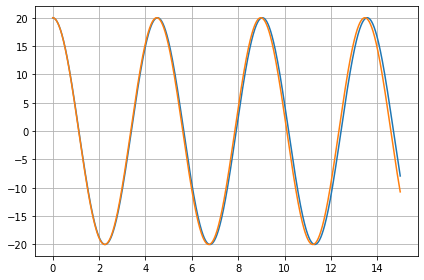

In [92]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
ax.plot(t_pts, 180./np.pi * phi)
ax.grid()
ax.plot(t_pts, 180./np.pi * phi_lo)
fig.tight_layout()  # make the spacing of subplots nicer


We could analyze the solutions at this stage, but instead let's improve the plot and see how to save it.

### More systematic plotting

Here we see examples of applying limits to the x and y axes as well as labels and a title.

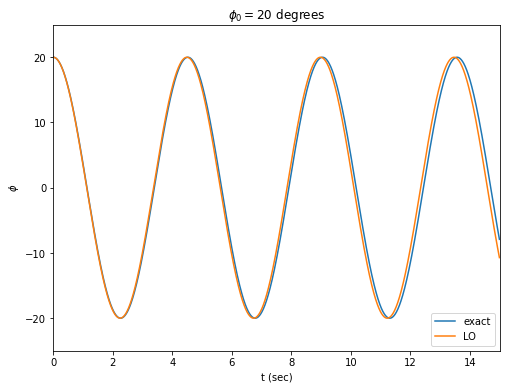

In [93]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0.,15.)
ax.set_ylim(-25.,25.)
ax.set_xlabel('t (sec)')
ax.set_ylabel(r'$\phi$')
ax.set_title(r'$\phi_0 = 20$ degrees')
# Watch out: The empty space behind the comma matters, do not remove!!!
line_exact, = ax.plot(t_pts, 180./np.pi * phi, label='exact')
line_lo, = ax.plot(t_pts, 180./np.pi * phi_lo, label='LO')
ax.legend()

# save the figure
fig.savefig('p01_pendulum_solutions.png', bbox_inches='tight')

### Now let's add some widgets!

We can use widgets to examine arbitrary angles.

In [94]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

def rad_to_deg(theta_rad):
    """Take as input an angle in radians and return it in degrees."""
    return 180./np.pi * theta_rad

def deg_to_rad(theta_deg):
    """Take as input an angle in degrees and return it in radians."""
    return np.pi/180. * theta_deg


In [95]:
def plot_exact_and_small_angle(phi0_deg=0):
    phi0_rad = deg_to_rad(phi0_deg)
    phi_rad = solve_for_phi_all(phi0_rad, t_max=15.)
    phi_deg = rad_to_deg(phi_rad)
    phi_lo_deg = rad_to_deg(phi_lo_rad)
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    # Watch out: The empty space behind the comma matters, do not remove!!!
    line_exact, = ax.plot(t_pts, phi_deg, label='exact')
    ax.legend()
    ax.set_xlim(0.,15.)
    #ax.set_ylim(-90.,90.)
    ax.set_xlabel('t (sec)')
    ax.set_ylabel(r'$\phi$')
    ax.set_title(fr'$\phi_0 = {phi0_deg:.0f}$')
    plt.show()


In [96]:
interact(plot_exact_and_small_angle, phi0_deg=(0.,90.));

TypeError: can't multiply sequence by non-int of type 'float'

In [97]:
# to avoid the jiggling and do some formatting
phi0_deg_widget = widgets.FloatSlider(min=0., max=120.0, step=0.1, value=0.,
                                     description=r'$\phi_0$ (degrees)',
                                     readout_format='.0f',
                                     continuous_update=False
                                    )
interact(plot_exact_and_small_angle, phi0_deg=phi0_deg_widget);

TypeError: can't multiply sequence by non-int of type 'float'

Now that we have played through the leading-order approximation of the Lagrangian, you may guess what is coming next.

<div class="alert alert-block alert-info">

1. Add (at least) **next-to-leading order corrections** to the small angle expansion of $\sin\phi$, and analyze their impact on the accuracy of your result. 
    
    Use the widgets to explore and identify ranges of angle where you notice interesting behavior, e.g., noticeable changes in the quality of the approximation. Create snapshot figures (or source code to produce them, as in the examples above) and use them to discuss your findings below.
    
    
2. **(Bonus)** Treat the exact solution as observed data, and the effective theory as an ansatz
    $$
    \begin{equation}
        V_n(\phi) = \sum_{k=1}^nc_k\phi^k\,.
    \end{equation}
    $$
    Determine the $c_i$'s by fitting them to the data, and check how well they compare with the exact coefficients that are determined by expanding the exact $V(\phi)=mgl\cos\theta$.
</div>

In [98]:
def ode_rhs_lo(u_vec, t, *params):
    """ 
    Right-hand side (rhs) of the EOM for the ideal pendulum, with 
    u_vec = [\phi, \dot\phi] and params = [g, R].  Returns the list of
    d(u_vec)/dt, as prescribed by the differential equation.
    
    """
    phi, phidot = u_vec[0], u_vec[1]
    c1 = 1
    return [phidot, -g*(c1*phi/R)] # second order phi derivative 


def ode_rhs_lo2(u_vec, t, *params):
    """ 
    Right-hand side (rhs) of the EOM for the ideal pendulum, with 
    u_vec = [\phi, \dot\phi] and params = [g, R].  Returns the list of
    d(u_vec)/dt, as prescribed by the differential equation.
    
    """
    phi, phidot = u_vec[0], u_vec[1]
    c1 = 1
    c2 = .2
    return [phidot, -g*(c1*phi/R + c2*phi**2/R**2)] # second order phi derivative 


In [99]:
def solve_for_phi_all(phi0, phidot0=0, t_min=0., t_max=1., g=9.8, R=5.):


    # absolute and relative tolerances for ode solver
    abserr = 1.0e-8
    relerr = 1.0e-6

    # initial conditions for [phi, phidot]
    u0_vec = [phi0, phidot0]

    t_pts = np.arange(t_min, t_max, 0.01)

    # Integrate the differential equations
    phi, phidot = odeint(ode_rhs_exact, u0_vec, t_pts, args=(g,R), 
                     atol=abserr, rtol=relerr).T
    phi_1o, phidot_lo =  odeint(ode_rhs_lo, u0_vec, t_pts, args=(g,R), 
                     atol=abserr, rtol=relerr).T
    phi_lo2, phidot_lo2 =  odeint(ode_rhs_lo2, u0_vec, t_pts, args=(g,R), 
                     atol=abserr, rtol=relerr).T
    
    return t_pts, phi, phidot, phi_lo, phidot_lo, phi_lo2, phidot_lo2

In [100]:
phi0 = np.pi/180 * 20.
t_pts, phi, phidot, phi_lo, phidot_lo, phi_lo2, phidot_lo2 = solve_for_phi_all(phi0, t_max=15.)

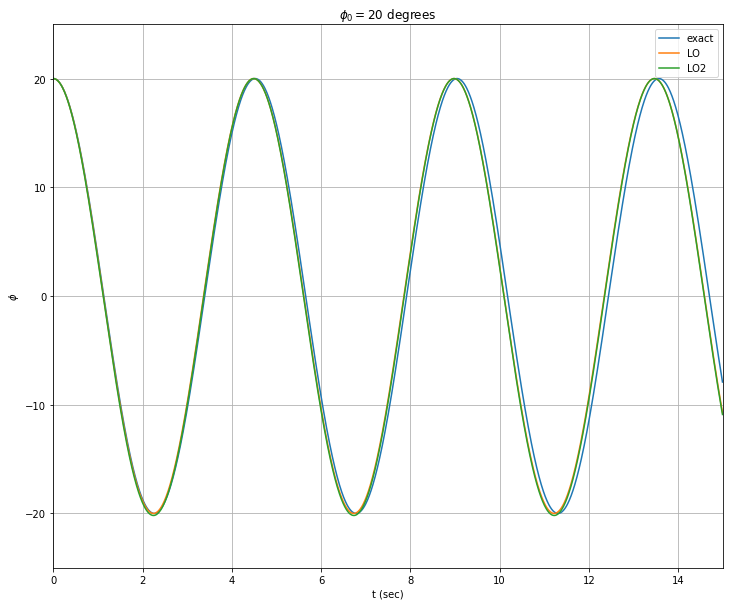

In [101]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0.,15.)
ax.set_ylim(-25.,25.)
ax.set_xlabel('t (sec)')
ax.set_ylabel(r'$\phi$')
ax.set_title(r'$\phi_0 = 20$ degrees')
# Watch out: The empty space behind the comma matters, do not remove!!!
line_exact, = ax.plot(t_pts, 180./np.pi * phi, label='exact')
line_lo, = ax.plot(t_pts, 180./np.pi * phi_lo, label='LO')
line_lo2, = ax.plot(t_pts, 180./np.pi * phi_lo2, label= 'LO2')
ax.legend()
ax.grid()

# save the figure
fig.savefig('p01_pendulum_solutions.png', bbox_inches='tight')

# 3. Damped Pendulum

Let us now consider a pendulum that is also subject to a drag force $\vec{F} = -\beta \dot{\vec{r}}$. 

## 3.1 Analytical Derivation

<div class="alert alert-block alert-info">

1. Construct the dissipation function.
2. Derive the Lagrange equations with the explicit drag term.
3. Solve the LO theory for the underdamped case and determine the time by which a small-amplitude oscillation has been reduced by a factor $1/e$.

</div>


The equation of motion (as demonstrated earlier) for a simple pendulum is given as:
$$ -mglsin\theta = ml^2\ddot{\phi}$$
At this point we will add a drag component to the force equation:
$$\vec{F} = -\beta \dot{\vec{r}}$$
Where we know that $\dot{\vec{r}} = l\dot{\phi}\hat{\phi} + l\hat{r}$ from a change of coordinates.  This then gives the drag force as $\vec{F} = -\beta l\dot{\phi}\hat{\phi} - \beta l\hat{r}$.  The Euler-Lagrange equation now gives:
$$ ml\ddot{\phi}+ \beta l\dot{\phi} + mgsin\theta = 0 $$ 
This reduces too:
$$ \ddot{\phi}+ \frac{\beta}{m}\dot{\phi} + \frac{g}{l}sin\theta = 0 $$
Once solved for $\ddot{\phi}$ this becomes:
$$ \ddot{\phi} = -\frac{\beta}{m}\dot{\phi} - \frac{g}{l}sin\theta $$
We can then apply a small angle approximation where $ sin\theta \approx \theta $ to get this differential equation as:
$$ \ddot{\phi} = -\frac{\beta}{m}\dot{\phi} - \frac{g}{l}\theta $$


## 3.2 Numerical Solution

<div class="alert alert-block alert-info">

1. Solve the exact and LO theories numerically for the underdamped case (make a suitable choice for $\beta$ and $m$.
2. Discuss qualitatively how the decay time of the exact solution changes for different initial amplitudes. 

</div>



In [124]:
def ode_rhs_exact(u_vec, t, *params):
    """ 
    Right-hand side (rhs) of the differential equation, with 
    u_vec = [\phi, \dot\phi] and params = [g, R].  Returns the list of
    d(u_vec)/dt, as prescribed by the differential equation.
    
    """
    phi, phidot = u_vec[0], u_vec[1]       # extract phi and phidot from the passed vector
    g, R = params[0], params[1]              # extract g and R from the passed parameters
    b, m = params[2], params[3]
    return [ u_vec[1], -(g/R)*np.sin(phi)-(b/m)*phidot ]

def ode_rhs_lo(u_vec, t, g, R, b, m):
    """ 
    Right-hand side (rhs) of the EOM for the ideal pendulum, with 
    u_vec = [\phi, \dot\phi] and params = [g, R].  Returns the list of
    d(u_vec)/dt, as prescribed by the differential equation.
    
    """
    phi, phidot = u_vec[0], u_vec[1]
    c1 = 1.
    c2 = b/m
    return [phidot, -g*(c1*phi/R)-c2*phidot] # second order phi derivative 

def solve_for_phi_all(phi0, phidot0=0, t_min=0., t_max=1., g=9.8, R=5., b=.7, m=2.):
    
    # absolute and relative tolerances for ode solver
    abserr = 1.0e-8
    relerr = 1.0e-6

    # initial conditions for [phi, phidot]
    u0_vec = [phi0, phidot0]

    t_pts = np.arange(t_min, t_max, 0.01)

    # Integrate the differential equations
    phi3, phidot3 = odeint(ode_rhs_exact, u0_vec, t_pts, args=(g,R,b,m), 
                     atol=abserr, rtol=relerr).T
    phi_1o3, phidot_lo3 =  odeint(ode_rhs_lo, u0_vec, t_pts, args=(g,R,b,m), 
                     atol=abserr, rtol=relerr).T
    
    return t_pts, phi3, phidot3

In [125]:
phi3 = np.pi/180 * 20.
t_pts, phi3, phidot3 = solve_for_phi_all(phi3, t_max=15.)

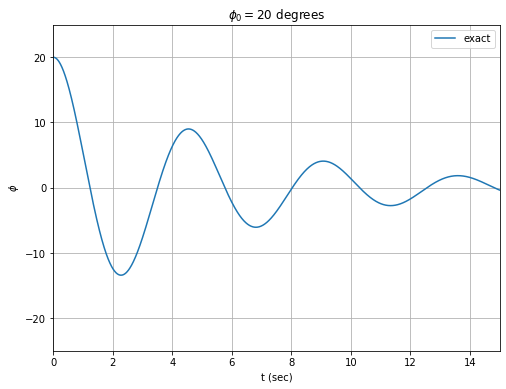

In [128]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0.,15.)
ax.set_ylim(-25.,25.)
ax.set_xlabel('t (sec)')
ax.set_ylabel(r'$\phi$')
ax.set_title(r'$\phi_0 = 20$ degrees')
# Watch out: The empty space behind the comma matters, do not remove!!!
line_exact3, = ax.plot(t_pts, 180./np.pi * phi3, label='exact')
ax.legend()
ax.grid()

# save the figure
fig.savefig('p01_pendulum_solutions.png', bbox_inches='tight')